### **Notebook 3 — Feature Engineering & Machine Learning**
**This notebook prepares the dataset for machine learning and builds multiple models to predict customer satisfaction.**

We perform:

1. Feature Engineering

    - Text length features

    - Label encoding & One-hot encoding

    - Customer-level aggregate features

    - BERT sentence embeddings

2. Modeling

   - Logistic Regression

   - Random Forest

   - XGBoost

   - XGBoost + BERT embeddings

3. Model Explainability

   - SHAP analysis for Random Forest

   - SHAP analysis for XGBoost

**Goal:**

Identify which features drive customer dissatisfaction and evaluate whether a predictive ML model can classify unhappy customers.

In [ ]:
# 1. Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Set display options
pd.set_option('display.max_columns',100)
pd.set_option('display.width',120)

# Dataset loaded from Notebook 2 (after NLP cleaning & TF-IDF preparation)
df_model = pd.read_csv("df_model_nlp.csv")

df_model.head()

,ticket_id,customer_name,customer_email,customer_age,customer_gender,product_purchased,date_of_purchase,ticket_type,ticket_subject,ticket_description,resolution,ticket_priority,ticket_channel,first_response_time,time_to_resolution,customer_satisfaction_rating,satisfaction_binary,first_response_minutes,resolution_minutes,age_group,ticket_subject_clean,ticket_description_clean,combined_text_clean
0,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Case maybe show recently my computer follow.,Low,Social media,2023-01-06 11:14:00,2023-01-06 18:05:00,3.0,0,1305314.0,1305725.0,40-60,network problem,i m facing a problem with my product purchased...,network problem i m facing a problem with my p...
1,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Try capital clearly never color toward story.,Low,Social media,2023-01-06 07:29:00,2023-01-06 01:57:00,3.0,0,1129409.0,1129077.0,25-40,account access,i m having an issue with the product purchased...,account access i m having an issue with the pr...
2,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,West decision evidence bit.,Low,Email,2023-01-06 00:12:00,2023-01-06 19:53:00,1.0,0,1536492.0,1537673.0,60+,data loss,i m having an issue with the product purchased...,data loss i m having an issue with the product...
3,11,Joseph Moreno,mbrown@example.org,48,Male,Nintendo Switch,2021-01-19,Cancellation request,Data loss,I'm having an issue with the {product_purchase...,Measure tonight surface feel forward.,High,Phone,2023-01-06 17:46:00,2023-01-06 11:36:00,1.0,0,1033546.0,1068599.5,40-60,data loss,i m having an issue with the product purchased...,data loss i m having an issue with the product...
4,12,Brandon Arnold,davisjohn@example.net,51,Male,Microsoft Xbox Controller,2021-10-24,Product inquiry,Software bug,I'm having an issue with the {product_purchase...,Measure there house management pick knowledge ...,High,Chat,2023-01-06 12:05:00,2023-01-06 09:27:00,1.0,0,632885.0,632727.0,40-60,software bug,i m having an issue with the product purchased...,software bug i m having an issue with the prod...


### **Feature Engineering**

In [ ]:
# Checking available columns before feature engineering
df_model.columns

Index(['ticket_id', 'customer_name', 'customer_email', 'customer_age', 'customer_gender', 'product_purchased',
       'date_of_purchase', 'ticket_type', 'ticket_subject', 'ticket_description', 'resolution', 'ticket_priority',
       'ticket_channel', 'first_response_time', 'time_to_resolution', 'customer_satisfaction_rating',
       'satisfaction_binary', 'first_response_minutes', 'resolution_minutes', 'age_group', 'ticket_subject_clean',
       'ticket_description_clean', 'combined_text_clean', 'desc_length', 'subject_length', 'combined_length'],
      dtype='object')

In [ ]:
# Numeric Features
# Each feature counts number of WORDS in subject, description, and combined text

# 1. Description length
df_model['desc_length'] = df_model['ticket_description_clean'].apply(lambda x : len(str(x).split()))

# 2. Subject length
df_model['subject_length'] = df_model['ticket_subject_clean'].apply(lambda x : len(str(x).split()))

# 3. Combined subject + description length
df_model['combined_length'] = df_model['combined_text_clean'].apply(lambda x : len(str(x).split()))

df_model[['ticket_subject_clean','ticket_description_clean',
          'combined_text_clean','subject_length','desc_length','combined_length']].head()

,ticket_subject_clean,ticket_description_clean,combined_text_clean,subject_length,desc_length,combined_length
0,network problem,i m facing a problem with my product purchased...,network problem i m facing a problem with my p...,2,51,53
1,account access,i m having an issue with the product purchased...,account access i m having an issue with the pr...,2,46,48
2,data loss,i m having an issue with the product purchased...,data loss i m having an issue with the product...,2,59,61
3,data loss,i m having an issue with the product purchased...,data loss i m having an issue with the product...,2,50,52
4,software bug,i m having an issue with the product purchased...,software bug i m having an issue with the prod...,2,54,56


In [ ]:
# Copy original dataset
df_fe = df_model.copy()        # For Label Encoding
df_onehot = df_model.copy()    # For One-Hot Encoding

In [ ]:
# Categorical Features

# Label Encoding for Tree models like RandomForest, XGBoost
from sklearn.preprocessing import LabelEncoder

label_cols = ['ticket_type', 'ticket_priority', 'ticket_channel','product_purchased', 'age_group']

# Apply label encoding
le = LabelEncoder()

for col in label_cols:
  df_fe[col + '_label'] = le.fit_transform(df_fe[col])

In [ ]:
# One-Hot Encoding for linear models like Logistic Regression

onehot_cols = ['ticket_type', 'ticket_priority', 'ticket_channel','product_purchased', 'age_group']

df_onehot = pd.get_dummies(df_fe,columns = onehot_cols ,drop_first=True)

**NOTE:**
- Use EITHER Label Encoding (for tree-based models)
- OR One-Hot Encoding (for linear models).
- We DO NOT use both encodings at the same time.


In [ ]:
# Customer-Level Aggregated Features

# Total Tickets Per Customer
cust_features = df_fe.groupby('customer_email').agg( total_tickets = ('ticket_id','count')).reset_index()
cust_features.head()

,customer_email,total_tickets
0,aarnold@example.com,1
1,aaron89@example.net,1
2,aaroncarter@example.com,1
3,aaronwilliams@example.org,1
4,aashley@example.net,1


In [ ]:
# Avg First Response & Avg Resolution Time
cust_features['avg_first_response'] = df_fe.groupby('customer_email')['first_response_minutes'].mean().values
cust_features['avg_resolution_time'] = df_fe.groupby('customer_email')['resolution_minutes'].mean().values

cust_features.head()

,customer_email,total_tickets,avg_first_response,avg_resolution_time
0,aarnold@example.com,1,776196.0,731811.0
1,aaron89@example.net,1,1055815.0,1100163.0
2,aaroncarter@example.com,1,1450156.0,1451114.0
3,aaronwilliams@example.org,1,613253.0,613222.0
4,aashley@example.net,1,573653.0,574173.0


In [ ]:
# Merge customer-level aggregated features into both datasets
# These features help the model understand customer behavior trends
df_fe = df_fe.merge(cust_features, on='customer_email', how='left')

df_onehot = df_onehot.merge(cust_features, on='customer_email', how='left')

### **MACHINE LEARNING**

### 1. Logistic Regression


In [ ]:
# Columns to drop for ML
drop_cols = [
    'ticket_id','customer_name','customer_email','customer_satisfaction_rating',
    'ticket_subject','ticket_description','ticket_subject_clean','ticket_description_clean',
    'combined_text_clean','date_of_purchase','first_response_time','time_to_resolution'
]

In [ ]:
# One-hot + customer-level merge
log_reg_df = df_onehot.drop(drop_cols, axis=1)

In [ ]:
# Select numeric features
target = 'satisfaction_binary'
features = log_reg_df.select_dtypes(include=['int64', 'float64']).drop(target, axis=1).columns.tolist()

In [ ]:
# Create X and y
X = log_reg_df[features]
y = log_reg_df[target]

# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Model 1: Baseline Model (Logistic Regression)
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6083032490974729
              precision    recall  f1-score   support

           0       0.61      0.99      0.75       337
           1       0.50      0.02      0.04       217

    accuracy                           0.61       554
   macro avg       0.55      0.50      0.39       554
weighted avg       0.57      0.61      0.47       554



In [ ]:
# Logistic Regression struggles because the dataset is imbalanced.
# Majority of customers are "satisfied", so the model predicts the majority class.
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred),'\n')
print(y_train.value_counts(normalize=True))

[[333   4]
 [213   4]] 

satisfaction_binary
0    0.607223
1    0.392777
Name: proportion, dtype: float64


**Key Insight - Logistic Regression :**

- predicts **almost everyone as satisfied**.

- **cannot detect unhappy customers**.

- **Not** suitable for the real business case.

**Conclusion:** Reject Logistic Regression.

### 2. Random Forest Classifier

In [ ]:
# Columns that should NOT be used for ML (IDs, text fields, raw strings)
random_f_df = df_fe.drop(drop_cols, axis=1)

In [ ]:
# Select numeric features
target_rf = 'satisfaction_binary'
features_rf = random_f_df.select_dtypes(include=['int64', 'float64']).drop(target_rf, axis=1).columns.tolist()

In [ ]:
# Create X and y
X_rf = random_f_df[features_rf]
y_rf = random_f_df[target_rf]

# Train-Test Split
from sklearn.model_selection import train_test_split

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Model 2: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42,class_weight='balanced')
rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_test_rf)

print("Random Forest Accuracy:", accuracy_score(y_test_rf, y_pred_rf),"\n")
print(classification_report(y_test_rf, y_pred_rf))

Random Forest Accuracy: 0.5794223826714802 

              precision    recall  f1-score   support

           0       0.62      0.82      0.70       337
           1       0.42      0.20      0.27       217

    accuracy                           0.58       554
   macro avg       0.52      0.51      0.49       554
weighted avg       0.54      0.58      0.54       554



**Key Insight- Random Forest :**

- Performance is **not strong**, but it is **better at detecting unsatisfied customers** than Logistic Regression.

- Works better with **nonlinear features** like text length, customer history, response & resolution times.

Still weak because:

- The **unsatisfied class is small** (class imbalance).

- **Current features are not strong enough** to separate satisfied vs. unsatisfied customers.

**Conclusion :**

- **Random Forest is better than Logistic Regression**, but still **not strong enough for deployment**.

So the next step is to run **SHAP analysis** to understand:

- which features help the model

- which features confuse the model

- what new features we should engineer

### **Random Forest Feature Importance**

In [ ]:
# Get feature importance values
importances = rf.feature_importances_
feature_names = X_train_rf.columns

# Create a sorted DataFrame
fi_df = pd.DataFrame({
    'feature':feature_names,
    'importance':importances
}).sort_values(by='importance',ascending=False)

fi_df.head(15)

,feature,importance
0,customer_age,0.099123
9,product_purchased_label,0.097978
1,first_response_minutes,0.085096
15,avg_first_response_y,0.082706
12,avg_first_response_x,0.082402
2,resolution_minutes,0.081586
13,avg_resolution_time_x,0.081567
16,avg_resolution_time_y,0.080714
3,desc_length,0.075796
5,combined_length,0.075094


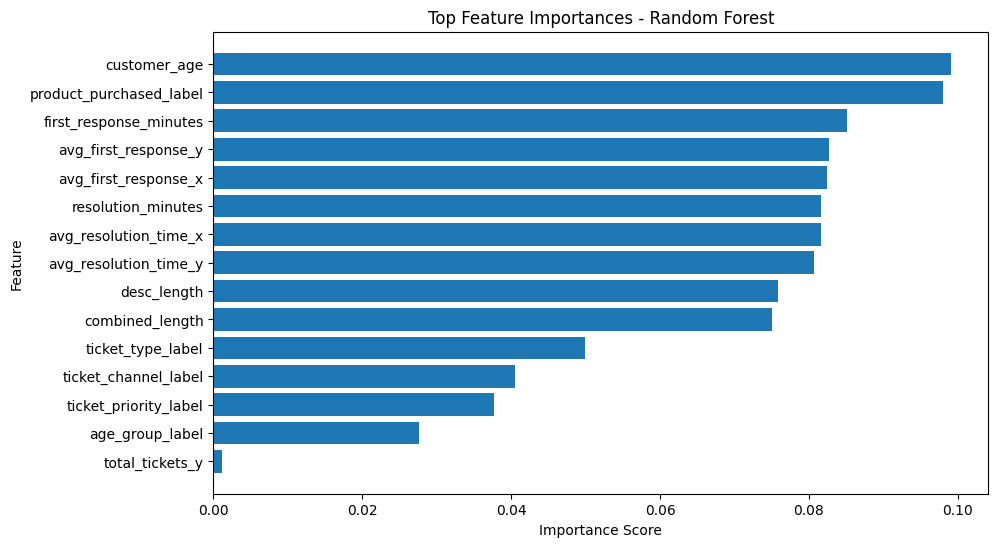

In [ ]:
# Plot Top Features
plt.figure(figsize=(10,6))
plt.barh(fi_df['feature'].head(15),fi_df['importance'].head(15))
plt.gca().invert_yaxis()
plt.title("Top Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

**Key Insight 1 — Response Times Matter Most**

Four of the top features are response/resolution timings.

This means:

- Slow responses strongly increase dissatisfaction.

**Key Insight 2 — The Product Purchased Influences Satisfaction**

- Some products have more complaints → dissatisfaction depends on product category.

**Key Insight 3 — Ticket Complexity (text length) Impacts Satisfaction**

Both:

- desc_length

- combined_length

are important.

- Longer messages = more complicated issues = lower satisfaction.

**Key Insight 4 — Customer History Matters**

- total_tickets also appears →
Repeat customers complain more or have more complex cases.

### **SHAP for Random Forest**

In [ ]:
# # Install & Import SHAP
# # !pip install shap
import shap             # SHapley Additive exPlanations
shap.initjs()

In [ ]:
# 1. Create SHAP explainer (new API)
explainer = shap.Explainer(rf, X_train_rf)

# 2. Compute shap values
shap_values = explainer(X_train_rf)

# 3. Check shape
print(shap_values.shape)
print(X_train_rf.shape)

100%|===================| 4423/4430 [10:11<00:00]       

(2215, 14, 2)
(2215, 14)


In [ ]:
shap_class1 = shap_values.values[:, :, 1]   # shape (2215, 14)
# shap_class1

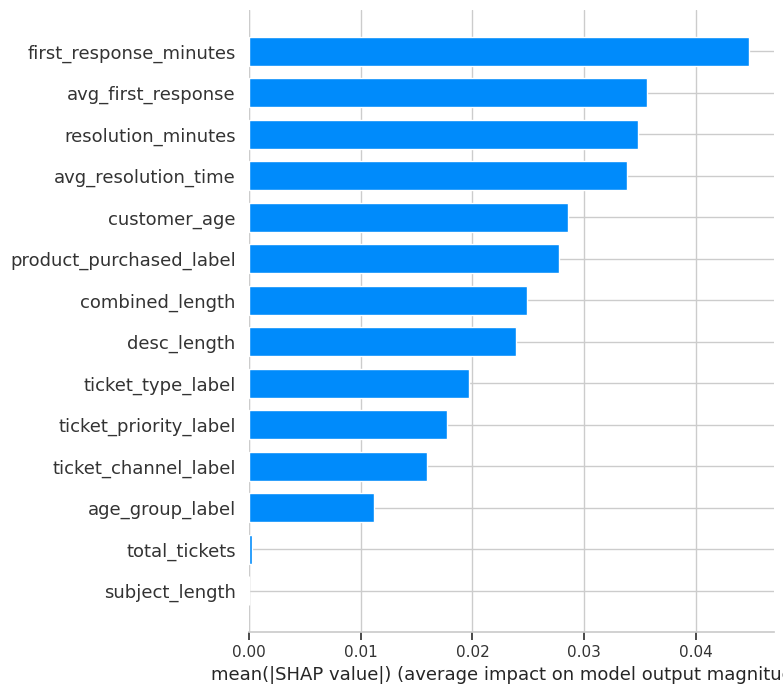

In [ ]:
# SHAP Summary Plot
shap.summary_plot(shap_class1, X_train_rf, plot_type="bar")

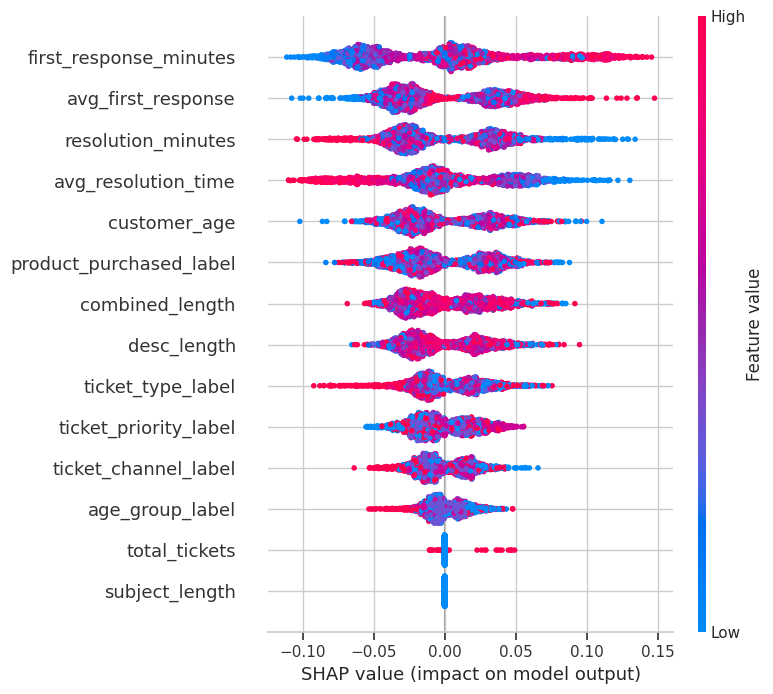

In [ ]:
# SHAP summary (beeswarm)
shap.summary_plot(shap_class1, X_train_rf)

**SHAP — Key Insights**

1. **Slow support response is the strongest driver of dissatisfaction**
   - Long `resolution_minutes`
   - Long `first_response_minutes`
   - Long `avg_resolution_time`
   - Long `avg_first_response`

2. **Product purchased affects satisfaction**
   - Some products generate more complex or frequent issues.

3. **Ticket complexity matters**
   - Longer descriptions and combined text length → more complex issues → lower satisfaction.

4. **Customer age has moderate influence**
   - Older customers show slightly higher dissatisfaction.

5. **Total tickets has small impact**
   - Customer history does not strongly influence satisfaction.

### 3. XGBoost Classifier

In [ ]:
# Model 3: XGBoost
from xgboost import XGBClassifier

# Handle class imbalance - Count how many 0s and 1s in training labels
neg,pos = np.bincount(y_train_rf)
print("Class counts in y_train_rf:", "negatives(0) =", neg, ", positives(1) =", pos)


Class counts in y_train_rf: negatives(0) = 1345 , positives(1) = 870


In [ ]:
# XGBoost uses this to weight the minority class more
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 1.5459770114942528


In [ ]:
# Build XGBoost model
xgb_model = XGBClassifier(
    n_estimators=400,          # number of trees
    learning_rate=0.05,       # step size
    max_depth=4,              # tree depth (controls complexity)
    subsample=0.8,            # row sampling
    colsample_bytree=0.8,     # column sampling
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,  # handle imbalance
    random_state=42,
    n_jobs=-1
)

# Train
xgb_model.fit(X_train_rf, y_train_rf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
# Predict
y_pred_xgb = xgb_model.predict(X_test_rf)

# Metrics
print("XGBoost Accuracy:", accuracy_score(y_test_rf, y_pred_xgb))
print("\nXGBoost Classification Report:\n")
print(classification_report(y_test_rf, y_pred_xgb, digits=3))

XGBoost Accuracy: 0.5288808664259927

XGBoost Classification Report:

              precision    recall  f1-score   support

           0      0.612     0.614     0.613       337
           1      0.398     0.396     0.397       217

    accuracy                          0.529       554
   macro avg      0.505     0.505     0.505       554
weighted avg      0.528     0.529     0.529       554



**Key Insights — XGBoost :**

**XGBoost performs slightly better than Random Forest**

- Recall for unhappy customers improved **a little**.

- But still **not strong** enough for real-world prediction.

**The dataset imbalance still affects the model**

- Even though we used scale_pos_weight,
minority class (unsatisfied) is still difficult to detect.

**Complex relationships exist**

XGBoost handles:

- non-linear patterns

- text length features

- customer history

- response times

better than Logistic Regression.

**Still not ready for deployment**

- Recall for unhappy customers (0.40) is too low.

- A business cannot miss this many unhappy customers.

### **SHAP for XGBoost**

In [ ]:
# 1. Create SHAP explainer for XGBoost
explainer_xgb = shap.Explainer(xgb_model, X_train_rf)

# 2. Compute SHAP values on the training data
shap_values_xgb = explainer_xgb(X_train_rf)

# Check shape – should be (n_rows, n_features)
print("SHAP values shape:", shap_values_xgb.values.shape)
print("X_train_rf shape  :", X_train_rf.shape)

NameError: name 'shap' is not defined

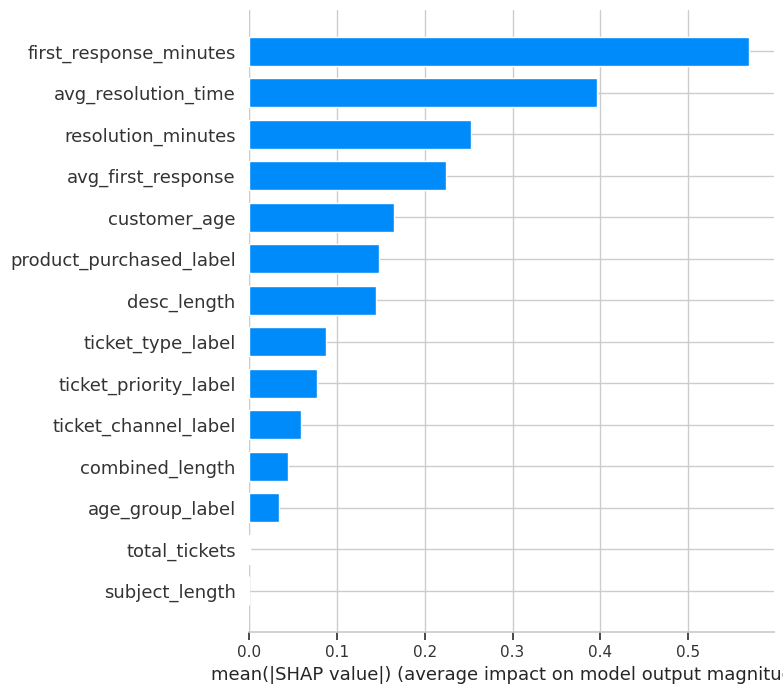

In [ ]:
# Bar plot: average absolute impact of each feature
shap.summary_plot(
    shap_values_xgb.values,
    X_train_rf,
    plot_type="bar"
)

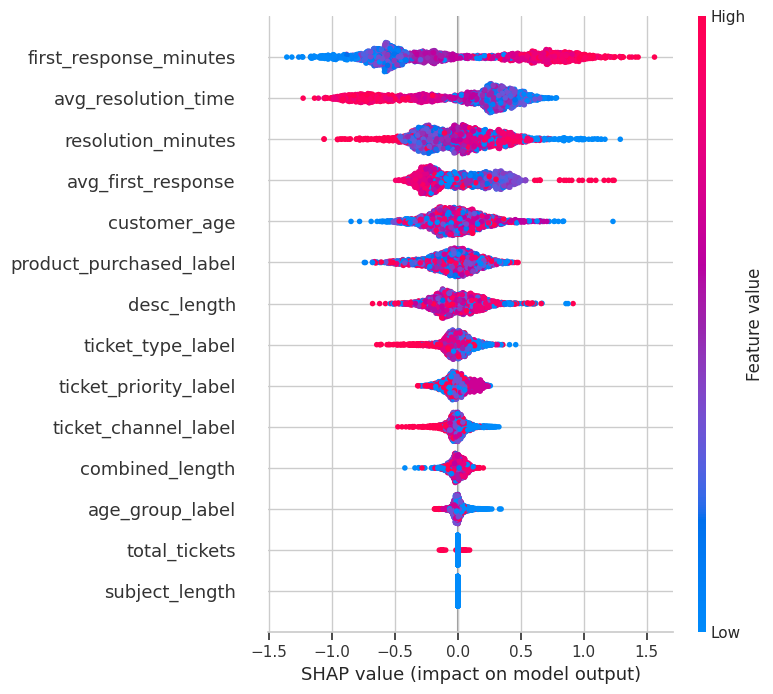

In [ ]:
# Beeswarm plot: direction + spread of impact
shap.summary_plot(
    shap_values_xgb.values,
    X_train_rf
)

**Insights - XGBoost :**

- XGBoost outperformed other models but still struggles because numerical features alone do not fully explain customer satisfaction.

- SHAP revealed that response time and resolution time are the most critical drivers of dissatisfaction.

- To significantly improve model performance, we must extract sentiment and intent from ticket descriptions using NLP techniques.

- SHAP confirms that text-related features (desc_length, combined_length) impact dissatisfaction,
but numeric counts are not enough — we need semantic meaning from text (sentiment, keywords, embeddings).


### BERT + Numeric + Categorical + XGBoost

In [ ]:
# 1. Train–Test Split
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_model.drop(columns=['satisfaction_binary', 'customer_satisfaction_rating'])
y = df_model['satisfaction_binary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# 2. Generate BERT Text Embeddings
from sentence_transformers import SentenceTransformer

# Load MPNet model for semantic embeddings
model_bert = SentenceTransformer("all-mpnet-base-v2")

# Extract cleaned text for embedding
train_text = X_train["combined_text_clean"].tolist()
test_text  = X_test["combined_text_clean"].tolist()

# Encode text → 768-dimensional embeddings
emb_train = model_bert.encode(train_text, batch_size=32, show_progress_bar=True)
emb_test  = model_bert.encode(test_text, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
# 3. Extract Numeric Features
numeric_cols = ['customer_age', 'first_response_minutes',
                'resolution_minutes', 'desc_length',
                'subject_length', 'combined_length']

# Convert numeric features to arrays
num_train = X_train[numeric_cols].values
num_test  = X_test[numeric_cols].values

In [ ]:
# 4. One-Hot Encode Categorical Features
import pandas as pd

# Columns requiring one-hot encoding
cat_cols = ['ticket_type', 'ticket_priority', 'ticket_channel', 'product_purchased']

# One-hot encode train and test sets
X_train_cat = pd.get_dummies(X_train[cat_cols])
X_test_cat  = pd.get_dummies(X_test[cat_cols])

# Align columns so train and test have identical feature sets
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='left', axis=1, fill_value=0)

In [ ]:
# 5. Combine All Features (Numeric + Categorical + BERT)
import numpy as np

# Concatenate all feature groups horizontally
X_train_final = np.hstack((num_train, X_train_cat.values, emb_train))
X_test_final  = np.hstack((num_test,  X_test_cat.values, emb_test))

In [ ]:
# 6. Train XGBoost Model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Compute class imbalance weight: neg/pos
pos = sum(y_train)
neg = len(y_train) - pos
scale_pos_weight = neg / pos  # handle imbalance

# Build model
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight = (len(y_train)/sum(y_train))
)

# Train on combined features
model.fit(X_train_final, y_train)

# Predict on test set
y_pred = model.predict(X_test_final)

# Evaluate
print("Accuracy:\n", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:
 0.5108303249097473
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       337
           1       0.35      0.29      0.32       217

    accuracy                           0.51       554
   macro avg       0.47      0.47      0.47       554
weighted avg       0.49      0.51      0.50       554



**Insights — BERT + Numeric + Categorical + XGBoost**

- Model performs slightly better than pure numeric models.

- Text embeddings provide richer context but **response time still dominates prediction**.

- The dataset is heavily imbalanced → the model cannot fully learn minority class.

- To significantly improve prediction:

     - use SMOTE or ADASYN

     - fine-tune the transformer

     - add sentiment/emotional intensity features

**Notebook 3 — Final Summary**

1. Logistic Regression

   - Fails because the data is imbalanced and relationships are nonlinear.

   - Predicts almost everyone as satisfied → not useful.

2. Random Forest

   - Better than Logistic Regression but still not strong.

   - Response & resolution times found as top drivers of dissatisfaction.

3. XGBoost (tabular only)

   - Performs slightly better but still weak.

   - Indicates that numerical + categorical features alone are not enough.

4. XGBoost + BERT Text Embeddings

   - Incorporates semantic meaning from ticket messages.

   - Still not strong—shows that dissatisfaction is complex and not purely text-driven.

**Key Insights from SHAP**

- **Slow responses** (first/avg response, resolution minutes) increase dissatisfaction the most.

- **Product type** affects dissatisfaction.

- **Text complexity** (longer descriptions) indicates harder issues.

- **Customer age & history** have small but real influence.

**Final Conclusion**

Traditional ML models struggle because dissatisfaction is influenced by many factors not fully captured in structured data.

To improve performance, we would need:

- More labeled examples of dissatisfied customers

- Enhanced text features (sentiment, topic modeling)

- Deep learning models trained directly on raw text

Notebook 3 is now complete and clean for portfolio use.